In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# for data load
import os

# for reading and processing images
import imageio
from PIL import Image
import tifffile
import cv2

# for visualizations
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow import keras

### Load data


In [ ]:
# Thay bằng đường dẫn đến mask và image
# Nhớ là phải lọc ảnh trước, vì có những ảnh không có mask (đã viết file helper trong project để xử lý vấn đề này)

# images_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-notmark/images'
# masks_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-notmark/masks'

images_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256/images'
masks_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256/masks'

# images_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/images'
# masks_folder = '/content/gdrive/MyDrive/nt-dataset/cus/256x256-data-augment/masks'

In [ ]:
list_image_name = os.listdir(images_folder)
list_masks_name = os.listdir(masks_folder) 

print(list_image_name)
print(len(list_image_name))

print(list_masks_name)
print(len(list_masks_name))

In [ ]:
def load_path(imgs_dir, masks_dir):
  images = []
  masks = []

  for file in os.listdir(images_folder):
    images.append(os.path.join(images_folder, file))

  for file in os.listdir(masks_folder):
    masks.append(os.path.join(masks_folder, file))

  return images, masks

In [ ]:
list_images_paths, list_masks_paths = load_path(images_folder, masks_folder)

In [ ]:
list_images_paths.sort()
print(list_images_paths)
print(len(list_images_paths))

list_masks_paths.sort()
print(list_masks_paths)
print(len(list_masks_paths))

In [ ]:
def show_img_with_mask(idx, images, masks):
  img = plt.imread(images[idx])
  mask = plt.imread(masks[idx])
  pair = np.concatenate((img, mask), axis=1)
  plt.figure(figsize=(15,20))
  plt.imshow(pair, cmap='gray')

In [ ]:
train_image_paths, test_image_paths = train_test_split(list_images_paths, test_size=0.2, random_state=30)

print(train_image_paths)
print(len(train_image_paths))

print(test_image_paths)
print(len(test_image_paths))

In [ ]:
def get_masks_corres(images_list):
  masks_list = []
  for i in range(0, len(images_list)):
    temp_list = images_list[i].split('/')
    temp_list[-2] = 'masks'
    masks_list.append('/'.join(temp_list))
  return masks_list

In [ ]:
train_mask_paths = get_masks_corres(train_image_paths)
test_mask_paths = get_masks_corres(test_image_paths)

print(train_image_paths)
print(train_mask_paths)
print(len(train_mask_paths))

print(test_image_paths)
print(test_mask_paths)
print(len(test_mask_paths))

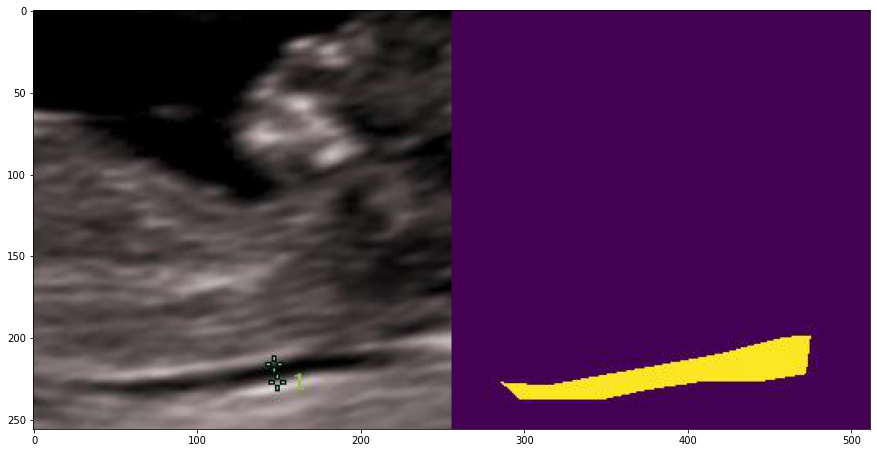

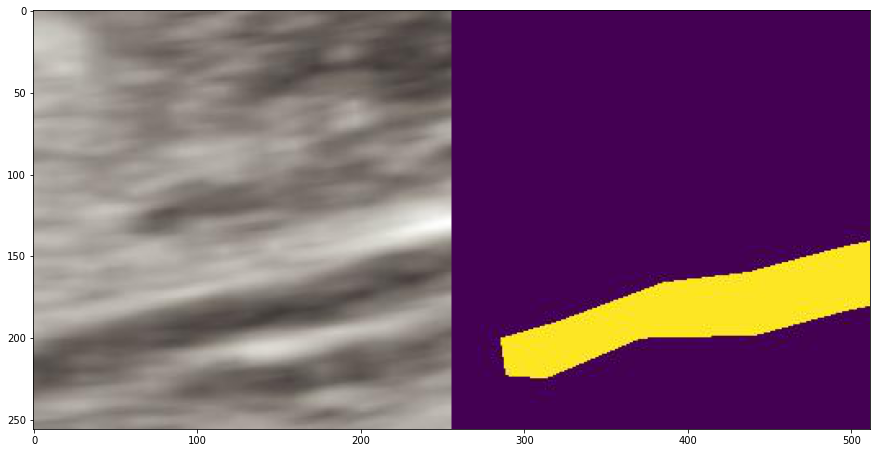

In [ ]:
for i in range(2):
  show_img_with_mask(i, train_image_paths, train_mask_paths)

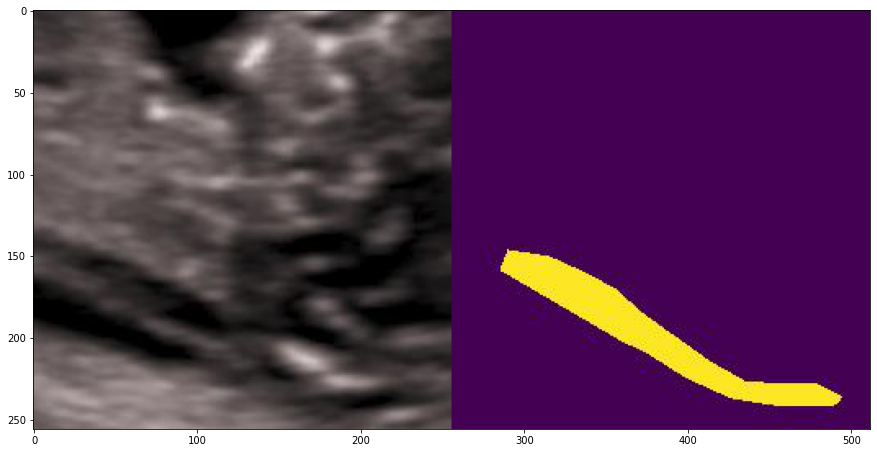

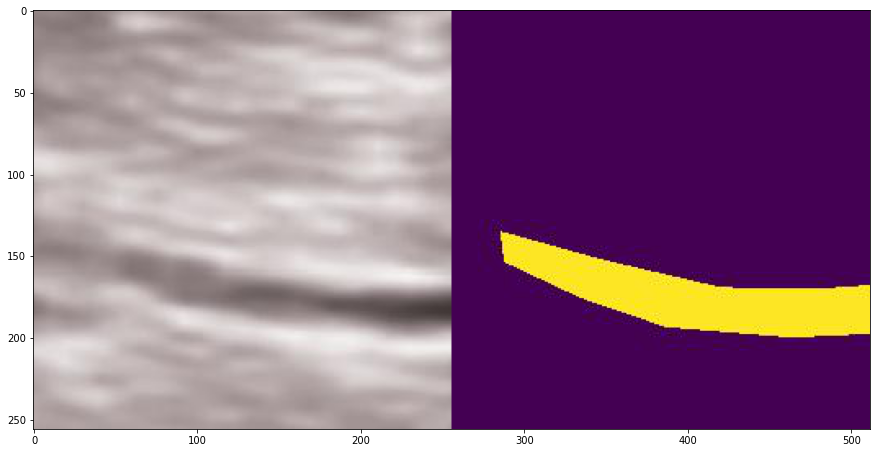

In [ ]:
for i in range(2):
  show_img_with_mask(i, test_image_paths, test_mask_paths)

### Preprocessing data

In [ ]:
target_shape_img = [256, 256, 3]
target_shape_mask = [256, 256, 1]

In [ ]:

def PreprocessData(image_list, mask_list, mode="train"):
    """
    - ảnh gốc có 3 kênh màu
    - ảnh mask chỉ có 1 kênh màu
    - cả hai đều được chuyển sang numpy array để lưu trữ
    """

    # Pull the relevant dimensions for image and mask
    number_of_example = len(image_list)                  # number of images
    image_height, image_width, image_channels = target_shape_img   # pull height, width, and channels of image
    mask_height, mask_width, mask_channels = target_shape_mask  # pull height, width, and channels of mask

    # Define X and Y as number of images along with shape of one image
    images = np.zeros((number_of_example, image_height, image_width, image_channels), dtype=np.float32)
    masks = np.zeros((number_of_example, mask_height, mask_width, mask_channels), dtype=np.int32)

    print('----------- Processing {0} images --------------'.format(mode))
    # Resize images and masks
    for (index, img) in enumerate(image_list):
        # convert image into an array of desired shape (3 channels)
        single_img = Image.open(img).convert('RGB')
        single_img = single_img.resize((image_height, image_width))
        single_img = np.reshape(single_img, (image_height, image_width, image_channels))
        single_img = single_img/256.
        images[index] = single_img
    print('----------- Processing {0} images done! --------------'.format(mode))
    print('\n')
    print('----------- Processing {0} mask --------------'.format(mode))
    for (index, mask) in enumerate(mask_list):
        # convert mask into an array of desired shape (1 channel)
        single_mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        single_mask = cv2.resize(single_mask, dsize=(mask_height, mask_width), interpolation=cv2.INTER_NEAREST)
        single_mask = np.asarray(single_mask)
        single_mask = single_mask[..., tf.newaxis]
        single_mask = np.reshape(single_mask, (mask_height, mask_width, mask_channels))
        single_mask = np.round(single_mask/255)
        single_mask = single_mask.astype(int)
        masks[index] = single_mask
    print('----------- Processing {0} mask done! --------------'.format(mode))
    print('\n')
    # result
    return images, masks

In [ ]:
# Process data using apt helper function
img_train, mask_train = PreprocessData(train_image_paths, train_mask_paths)
img_test, mask_test = PreprocessData(test_image_paths, test_mask_paths, "test")

# train
print("Train img Shape:", img_train.shape)
print("Train mask shape:", mask_train.shape)

# test
print("Test img Shape:", img_test.shape)
print("Mask img shape:", mask_test.shape)

# There are 2 classes
print(np.unique(mask_train))
print(np.unique(mask_test))

----------- Processing train images --------------
----------- Processing train images done! --------------


----------- Processing train mask --------------
----------- Processing train mask done! --------------


----------- Processing test images --------------
----------- Processing test images done! --------------


----------- Processing test mask --------------
----------- Processing test mask done! --------------


Train img Shape: (190, 256, 256, 3)
Train mask shape: (190, 256, 256, 1)
Test img Shape: (48, 256, 256, 3)
Mask img shape: (48, 256, 256, 1)
[0 1]
[0 1]


Text(0.5, 1.0, 'Processed Masked Image ')

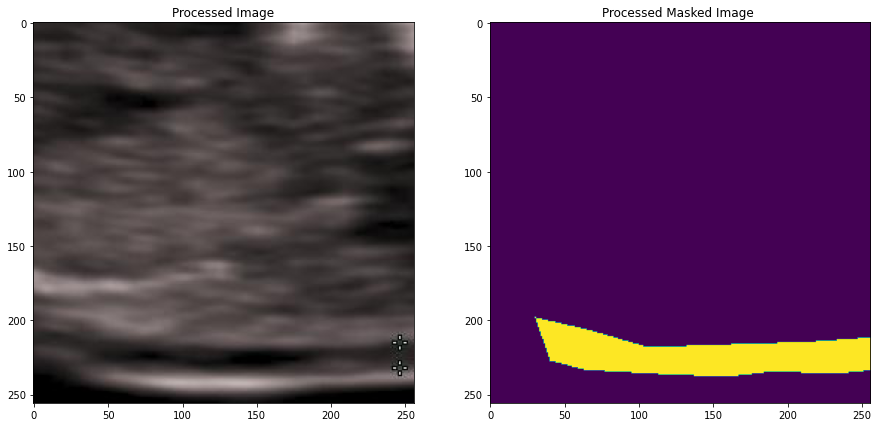

In [ ]:
 # Visualize the output
index_test = 145
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_train[index_test])
arr[0].set_title('Processed Image')
arr[1].imshow(mask_train[index_test, :, :, 0])
arr[1].set_title('Processed Masked Image ')

Text(0.5, 1.0, 'Processed Masked Image ')

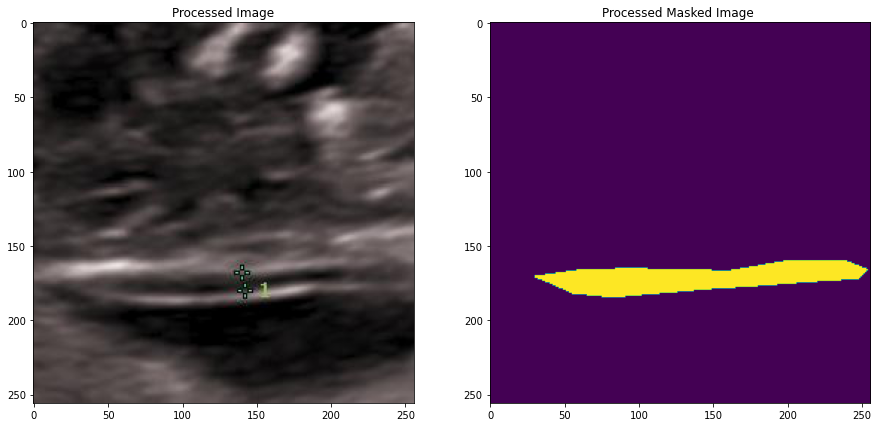

In [ ]:
# Visualize the output
index_test = 10
fig, arr = plt.subplots(1, 2, figsize=(15, 15))
arr[0].imshow(img_test[index_test])
arr[0].set_title('Processed Image')
arr[1].imshow(mask_test[index_test][:, :, 0])
arr[1].set_title('Processed Masked Image ')

In [ ]:
input_size = (256, 256, 3)
n_filters = 64
n_classes = 2

In [ ]:
def EncoderChildBlock(inputs, n_filters=n_filters, dropout_prob=0.3, max_pooling=True):
    # kernel_initializer để tránh việc vanishing gradients
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # Dropout  cho trường hợp overfitting
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)
    #  Max pooling với cửa sổ là 2x2
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2, 2))(conv)
    else:
        next_layer = conv

    # skip_connection chuyển input sang decoder tránh mất mát đặc trưng
    skip_connection = conv

    return next_layer, skip_connection

In [ ]:
def DecoderChildBlock(prev_layer_input, skip_layer_input, n_filters=n_filters):
    # Transpose convolution để tăng kích thước ảnh và giảm lượng kênh màu (đặc trưng) xuống một nửa
    up = Conv2DTranspose(n_filters,(3, 3), strides=(2, 2), padding='same')(prev_layer_input)

    # gộp 2 layer với nhau tránh mất mát thông tin
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='HeNormal')(conv)
    return conv

In [ ]:
def UNetCompiled(input_size=input_size, n_filters=n_filters, n_classes=n_classes):
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image 
    cblock1 = EncoderChildBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderChildBlock(cblock1[0], n_filters*2, dropout_prob=0.3, max_pooling=True)
    cblock3 = EncoderChildBlock(cblock2[0], n_filters*4, dropout_prob=0.3, max_pooling=True)
    cblock4 = EncoderChildBlock(cblock3[0], n_filters*8, dropout_prob=0.3, max_pooling=True)

    # Khối giữa
    cblock5 = EncoderChildBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderChildBlock(cblock5[0], cblock4[1], n_filters*8)
    ublock7 = DecoderChildBlock(ublock6, cblock3[1], n_filters*4)
    ublock8 = DecoderChildBlock(ublock7, cblock2[1], n_filters*2)
    ublock9 = DecoderChildBlock(ublock8, cblock1[1], n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size. 
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
X_train, X_valid, y_train, y_valid = img_train, img_test, mask_train, mask_test
# Compile the model
unet = UNetCompiled()
# Check the summary
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
# optimizer=Adam(learning_rate=1e-5)
batch_size = 32
epochs = 25
optimizer = Adam(learning_rate=1e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
unet.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
# Run
results = unet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/25
2/6 [=========>....................] - ETA: 15:20 - loss: 1.3356 - accuracy: 0.7874

In [ ]:
print(unet)

In [ ]:
unet.save('unet-7-256x256-25ep-94%.h5')

In [ ]:
def unet_predict(index_of_test):
  img = img_test[index_of_test][np.newaxis, ...]
  pred_y = unet.predict(img)
  pred_mask = tf.argmax(pred_y[0], axis=-1)
  return pred_mask

In [ ]:
index_test = 21
pred_mask = unet_predict(index_test)

_, arr = plt.subplots(1, 3, figsize=(15, 15))
arr[0].imshow(img_test[index_test])
arr[0].set_title('Processed image')
arr[1].imshow(mask_test[index_test][:, :, 0])
arr[1].set_title('Processed masked image ')
arr[2].imshow(pred_mask)
arr[2].set_title('Processed predict mask ')